In [3]:
import numpy as np
from qutip import *
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib
from math import factorial
from matplotlib import pyplot as plt
plt.rc('font', size=40)          # controls default text sizes
# plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=30)    # fontsize of the tick labels
# plt.rc('legend', fontsize=20)    # legend fontsize
# plt.rc('lines', markersize = 10)

matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 12, 8
# plt.rcParams['figure.dpi'] = 100
matplotlib.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid.which'] = "both"
props = dict(boxstyle='round', ec='black', fc='white')

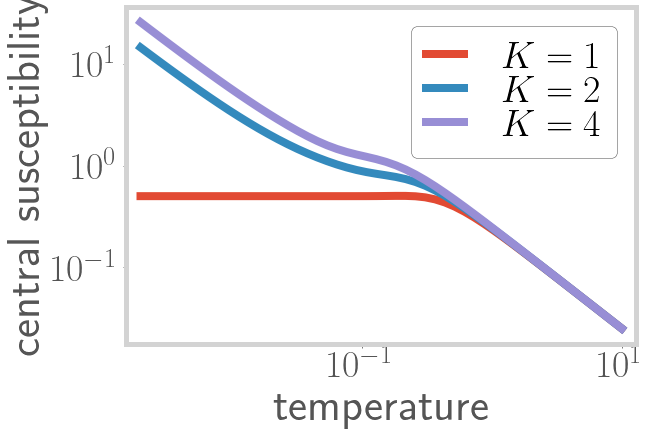

In [ ]:
def ham_chi(J, K, S, h1, h2):
    Sx, Sy, Sz = jmat(S)
    sx, sy, sz = jmat(1/2)
    H = 0
    for ch in range(K):
        H += J*tensor([Sx] + [identity(2)]*ch + [sx] + [identity(2)]*(K-ch-1))
        H += J*tensor([Sy] + [identity(2)]*ch + [sy] + [identity(2)]*(K-ch-1))
        H += J*tensor([Sz] + [identity(2)]*ch + [sz] + [identity(2)]*(K-ch-1))
        H += h2*tensor([identity(int(2*S+1))] + [identity(2)]*ch + [sz] + [identity(2)]*(K-ch-1))
        
    H += h1*tensor([Sz] + [identity(2)]*K)
    return H

def get_Z(J, K, S, h, beta):
    h1, h2 = h
    H = ham_chi(J, K, S, h1, h2)
    E = H.eigenenergies()
    Z = np.sum(np.exp(-beta*E))
    return Z


def get_chi_num(J, K, S, T_range,pos=0):
    delta_h = np.array([1e-4, 0]) if pos == 0 else (np.array([0, 1e-4]) if pos == 1 else np.array([1e-4, 1e-4]))
    chi = []
    for T in T_range:
        beta = 1/T
        Z = get_Z(J, K, S, [0,0], beta)
        Z_plus_deltaZ = get_Z(J, K, S, delta_h, beta)
        Z_plus_2deltaZ = get_Z(J, K, S, 2*delta_h, beta)
        dZdh = (Z_plus_deltaZ - Z)/sum(delta_h)
        d2Zdh2 = (Z_plus_2deltaZ + Z - 2*Z_plus_deltaZ)/(sum(delta_h)**2)
        chi.append(T * (d2Zdh2/Z - (dZdh/Z)**2))
        
    return chi

def chi():
    K0 = 2
    T_range = 10**np.linspace(-2.7, 1)
    cols = ['r', 'b', 'black']
    lstyles = ("--", "-", "-.")
    for delta, lst in tqdm(zip(np.arange(-1, 2), lstyles)):
        K = K0 + delta
        J = 1/K
        S = K0/2 - delta/2
        chi = get_chi_num(J, K, S, T_range,pos=0)
        plt.plot(T_range, np.array(chi), label=r"$\delta={}$".format(delta), color=cols[-1], ls=lst)
        cols = [cols[-1]] + cols[:-1]

    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel(r"$\chi$")
    plt.xlabel(r"$T$")
    plt.legend()
    plt.text(0.2, 0.2, r"$K_0 = 2$", bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("CentralFieldChiPowerlaw.pdf", bbox_inches='tight')
    plt.show()
chi()

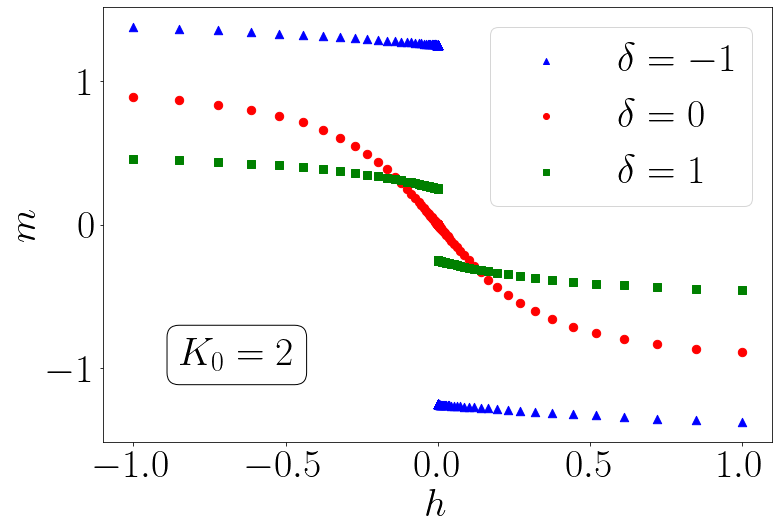

In [9]:
def mag():
    cols = ['r', 'b', 'g']
    mrks = ['o', '^', 's']
    K0 = 2
    for delta in [-1, 0, 1]:
        K = K0 + delta
        J = 1/K
        S = K0/2 - delta/2
        cols = [cols[-1]] + cols[:-1]
        mrks = [mrks[-1]] + mrks[:-1]
        hmin = 0
        hmax = -7
        h_range = 10**np.linspace(hmin, hmax, 100)
        y1 = []
        y2= []
        for h in h_range:
            H = ham_chi(J,K,S,h,0)
            E = H.eigenenergies()
            F1 = sum(E[E==min(E)])
            H = ham_chi(J,K,S,h-h/10,0)
            E = H.eigenenergies()
            F2 = sum(E[E==min(E)])
            dFdh = (F2 - F1)/(-h/10)
            y1.append(dFdh)
            H = ham_chi(J,K,S,-h,0)
            E = H.eigenenergies()
            F1 = sum(E[E==min(E)])
            H = ham_chi(J,K,S,-h+h/10,0)
            E = H.eigenenergies()
            F2 = sum(E[E==min(E)])
            dFdh = (F2 - F1)/(h/10)
            y2.append(dFdh)

        plt.scatter(h_range, y1, s=70, color=cols[-1], marker=mrks[-1])
        plt.scatter(-h_range, y2, s=70, color=cols[-1], marker=mrks[-1])
        plt.scatter([], [], marker=mrks[-1], color=cols[-1], label=r"$\delta={}$".format(delta))

    plt.legend()
    plt.xlabel(r"$h$")
    plt.ylabel(r"$m$")
    plt.text(0.2, 0.2, r"$K_0 = 2$", bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("discmagimpgen.pdf", bbox_inches="tight")
    
mag()

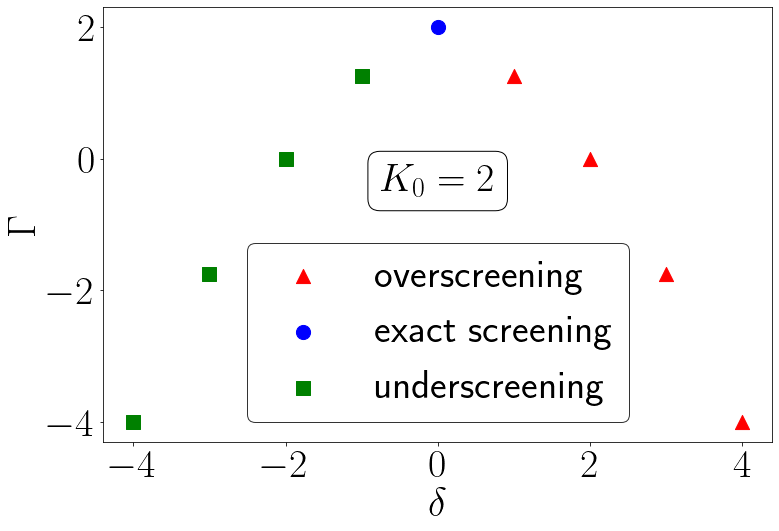

In [8]:
def compensation():
    cols = ['r', 'b', 'g']
    mrks = ['o', '^', 's']
    K0 = 2
    for delta in range(-4,5):
        K = K0 + delta
        # S = K0/2 - delta/2
        cols = [cols[-1]] + cols[:-1]
        mrks = [mrks[-1]] + mrks[:-1]
        gamma = 0.25 * ((K0+1)**2 - (abs(delta)+1)**2)
        if delta == 0:
            cl = 'b'
            mr = 'o'
        elif delta > 0:
            cl = 'r'
            mr = '^'
        else:
            cl = 'g'
            mr = 's'
        plt.scatter(delta, gamma, s=200, color=cl, marker=mr)

    plt.scatter([], [], color='r', s=200, marker='^', label='overscreening')
    plt.scatter([], [], color='b', s=200, marker='o', label='exact screening')
    plt.scatter([], [], color='g', s=200, marker='s', label='underscreening')

    plt.legend().get_frame().set_edgecolor('black')
    plt.xlabel(r"$\delta$")
    plt.ylabel(r"$\Gamma$")
    plt.text(0.5, 0.6, r"$K_0 = 2$", bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    # plt.savefig("degofcomp.pdf", bbox_inches="tight")
    
compensation()